In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
path = '../input/chest-xray-pneumonia/chest_xray/'
mean = torch.tensor([0.4822])
std = torch.tensor([0.2328])
transformations = transforms.Compose([transforms.Resize((64,64)), 
                              transforms.ToTensor(), 
                              transforms.Normalize(mean, std),
                             ])

In [5]:
train = ImageFolder(os.path.join(path, 'train'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(1)))
val = ImageFolder(os.path.join(path, 'val'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(1)))
test = ImageFolder(os.path.join(path, 'test'), transform=transformations)

In [6]:
print(train.__getitem__(0)[0].size(), train.__len__())
print(test.__getitem__(0)[0].size(), test.__len__())

print(len(train),len(test))

torch.Size([3, 64, 64]) 5216
torch.Size([3, 64, 64]) 624
5216 624


In [8]:
num_epoch=16
batch_size=326
learning_rate= 0.0002

In [9]:
train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5, padding=2), # [batch_size,3,64,64] -> [batch_size,16,64,64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                              # [batch_size,16,64,64] -> [batch_size,16,32,32]
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5, padding=2),# [batch_size,16,32,32] -> [batch_size,32,32,32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                              # [batch_size,32,32,32] -> [batch_size,32,16,16]
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5, padding=2),# [batch_size,32,16,16] -> [batch_size,64,16,16]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                               # [batch_size,64,16,16] -> [batch_size,64,8,8]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*8*8,1000),                                            # [batch_size,64*13*13] -> [batch_size,1000]
            nn.ReLU(),
            nn.Linear(1000, 100),                                                # [batch_size,1000] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100, 10)                                                 # [batch_size,100] -> [batch_size,10]
        )
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [33]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model=CNN().to(device)
loss_func=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [41]:
loss_arr=[]
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)
    y_=label.to(device)
    
    optimizer.zero_grad()
    
    output=model.forward(x)
    
    loss=loss_func(output,torch.max(y_, 1)[1])
    loss.backward()
    
    optimizer.step()
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(2.2238, grad_fn=<NllLossBackward>)
tensor(1.7954e-07, grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)


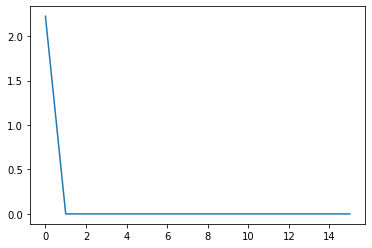

In [42]:
plt.plot(loss_arr)
plt.show()

In [43]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
    _,output_index=torch.max(output,1)
    total+=label.size(0)
    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 71.77914428710938%
